In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn
import xgboost as xgb
import seaborn as sns

In [65]:

# load the dataset
strokeData = pd.read_csv('necessaryfiles/healthcare-dataset-stroke-data.csv')
# Display the first few rows of the dataset and the dimensions of the matrix
print(strokeData.head())
shape = strokeData.shape
print(f"Shape: {shape}")

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  
Shape: (5110, 12)


Data Preprocessing (Delete missing values, check for duplicates, transform data points from categorical to numerical if necessary, etc.)

In [66]:
strokeData = strokeData.dropna() # Remove rows with missing values
numDuplicates = strokeData.duplicated().sum() # Count duplicate rows
print(numDuplicates) 

0


In [67]:
# transform categorical variables into numerical variables
strokeData['gender'] = strokeData['gender'].replace({'Male': 0, 'Female': 1, 'Other': 2})
strokeData['ever_married'] = strokeData['ever_married'].replace({'No': 0, 'Yes': 1})
strokeData['work_type'] = strokeData['work_type'].replace({'Private': 0, 'Self-employed': 1, 'children': 2, 'Govt_job': 3, 'Never_worked': 4})
strokeData['Residence_type'] = strokeData['Residence_type'].replace({'Urban': 1, 'Rural': 0})
strokeData['smoking_status'] = strokeData['smoking_status'].replace({'never smoked' : 1, 'formerly smoked': 0, 'smokes': 2, 'Unknown': 3})

# Index with patient_id
strokeData = strokeData.set_index('id')

/var/folders/dx/qdwnsv1j11365fsy3vnb86f80000gn/T/ipykernel_77660/3556266186.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  strokeData['gender'] = strokeData['gender'].replace({'Male': 0, 'Female': 1, 'Other': 2})
/var/folders/dx/qdwnsv1j11365fsy3vnb86f80000gn/T/ipykernel_77660/3556266186.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  strokeData['ever_married'] = strokeData['ever_married'].replace({'No': 0, 'Yes': 1})
/var/folders/dx/qdwnsv1j11365fsy3vnb86f80000gn/T/ipykernel_77660/3556266186.py:4: FutureWarning: Downcast

Summary Statistics and Visualization of Data Prior to Scaling

In [68]:
# Display statistical summary of the dataset
summary = strokeData.describe()
# print(summary)

# Calculate and display the median values for each column
medianValues = strokeData.median()
# print(medianValues)

# Calculate and display the mode values for each column
modeValues = strokeData.mode()
print(modeValues)

   gender   age  hypertension  heart_disease  ever_married  work_type  \
0     1.0  57.0           0.0            0.0           1.0        0.0   
1     NaN  78.0           NaN            NaN           NaN        NaN   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0             1.0              93.88  28.7             1.0     0.0  
1             NaN                NaN   NaN             NaN     NaN  


In [69]:
# Comparing the Dependent Variable with other features
# Number of stroke compared to not stroke

countStroke = strokeData['stroke'].value_counts()
print(f"Number of people who had a stroke: {countStroke[1]}\nNumber of people who did NOT have a stroke: {countStroke[0]}")

Number of people who had a stroke: 209
Number of people who did NOT have a stroke: 4700


In [71]:
strokeData.nunique()

gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3852
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

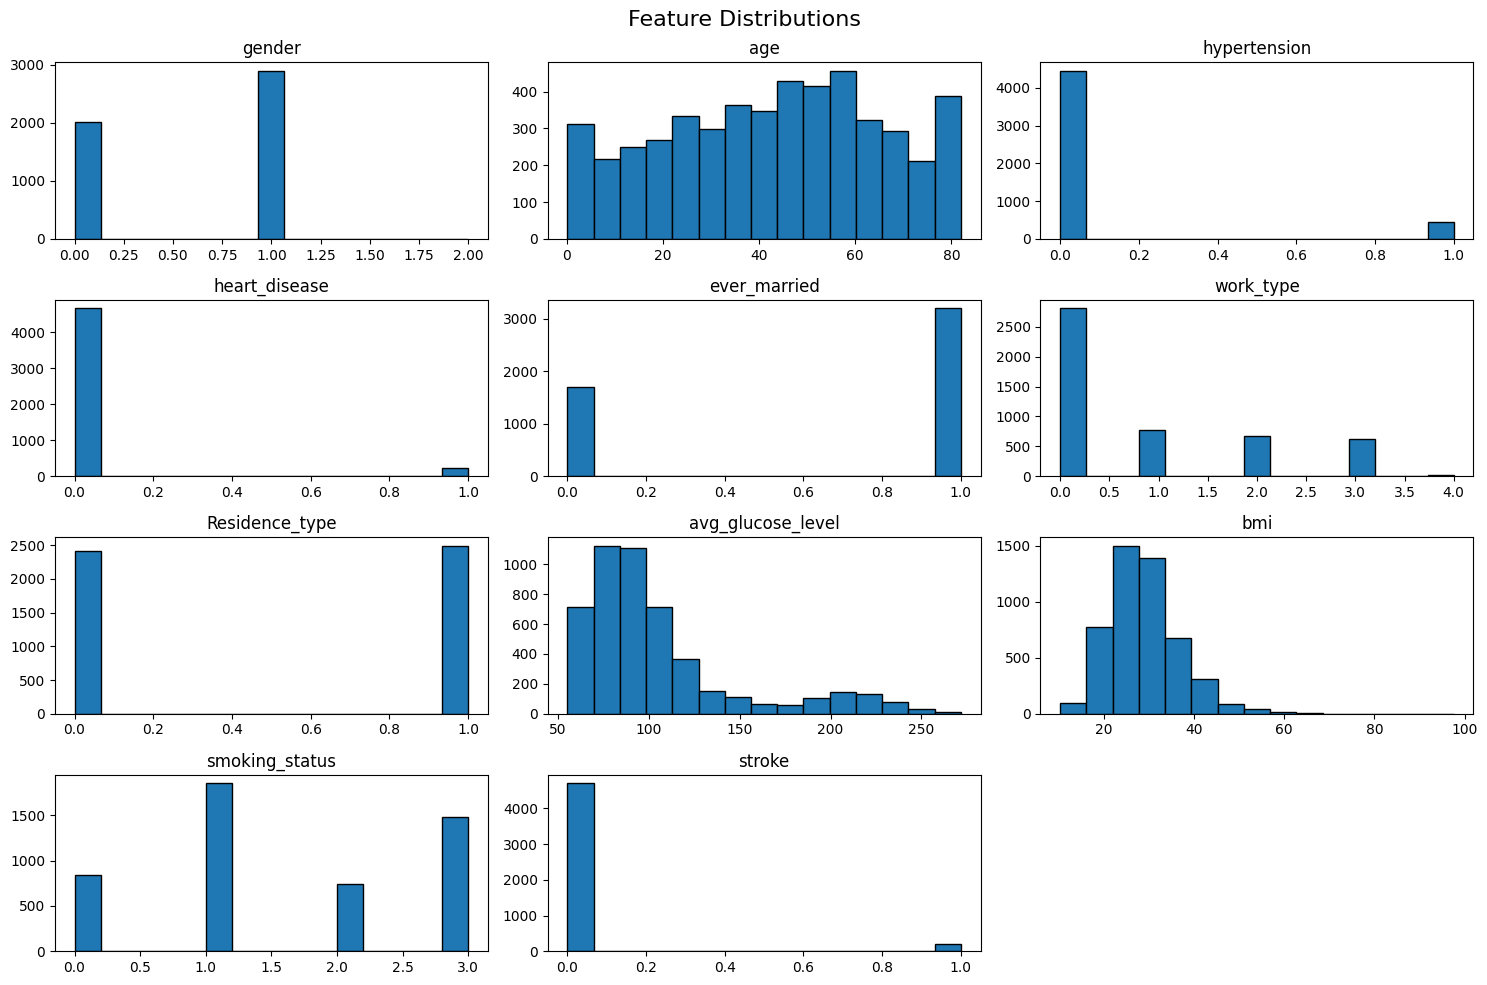

In [72]:
axes = strokeData.hist(bins=15, figsize=(15, 10), edgecolor='black')
plt.suptitle('Feature Distributions', fontsize=16)

for ax in axes.flatten():
    ax.grid(False)

plt.tight_layout()
plt.show()

In [73]:
# Show the mean values for when a person has had a stroke vs when they have not
strokeData.groupby('stroke').mean()

# Results indicate that age, hypertension, heart disease and avg_glucose_level change a lot

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
stroke,,,,,,,,,,
0,0.591277,41.760451,0.083191,0.043191,0.642128,0.841702,0.506596,104.003736,28.823064,1.601277
1,0.574163,67.712919,0.287081,0.191388,0.889952,0.665072,0.521531,134.571388,30.471292,1.191388


In [74]:
correlationMatrix = strokeData.corr()
print(correlationMatrix['stroke'].sort_values(ascending=False))

stroke               1.000000
age                  0.232331
hypertension         0.142515
avg_glucose_level    0.138936
heart_disease        0.137938
ever_married         0.105089
bmi                  0.042374
Residence_type       0.006031
gender              -0.007021
work_type           -0.032083
smoking_status      -0.075920
Name: stroke, dtype: float64


In [75]:
# sns.heatmap(correlationMatrix, annot=True, fmt=".2f", cmap='coolwarm')
# plt.title('Correlation Matrix Heatmap')
# plt.show()

# Heatmap does not add much value

Separate Dependent Variable

Split into Test and Train Sets

Feature Selection

In [77]:
X = strokeData.drop(columns=['stroke'])
y = strokeData['stroke']

print(X.shape)
print(y.shape)

(4909, 10)
(4909,)


In [78]:
# Need to convert to numpy arrays for model input
X = np.array(X)
y = np.array(y)

In [80]:
# 20% test size, 80% train size
from sklearn.model_selection import train_test_split
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=3)

In [81]:
# STANDARDIZE the Data

# Fns to compute mean and st.dev
def computeMeanStd(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0, ddof = 1)
    return mean, std

def standardize(X, mean, std):
    XStd = (X - mean) / std
    return XStd   

# compute mean and st.dev for the training set
meanTrain, stdTrain = computeMeanStd(XTrain)

# standardize both training and test sets
XTrainScaled = standardize(XTrain, meanTrain, stdTrain)
XTestScaled = standardize(XTest, meanTrain, stdTrain)

Feature Selection (try L1-norm Regularization, significance level, PCA)

In [83]:
from sklearn.linear_model import Lasso

# Lasso Regression Model
alpha = 0.01 # Higher alpha means more SPARSITY
lasso = Lasso(alpha=alpha)

# Fit the Lasso model to the standardized training data
lasso.fit(XTrainScaled, yTrain)

print("Coefficients of the Lasso Regression Model:", lasso.coef_)

# Below implies that Age, Hypertension, Heart Disease, and Average Glucose Level are the most important features for predicting a stroke
# Which also implies that gender, work type, residence type, and smoking status are less important features for predicting a stroke

Coefficients of the Lasso Regression Model: [-0.          0.03247814  0.00801594  0.01138953 -0.          0.
  0.          0.00359201 -0.         -0.        ]


Order of Most Important (l1 Regularizer): Age, Heart Disease, Hypertension, Average Glucose Level.

In [85]:
from sklearn.linear_model import Lasso

# Lasso Regression Model AGAIN with HIGHER ALPHA
alpha = 0.001 # Higher alpha means more SPARSITY
lasso = Lasso(alpha=alpha)

# Fit the Lasso model to the standardized training data
lasso.fit(XTrainScaled, yTrain)

print("Coefficients of the Lasso Regression Model:", lasso.coef_)

# Below implies that Gender, Work Type, and Smoking Status are the least important features for predicting a stroke

Coefficients of the Lasso Regression Model: [ 0.          0.05143458  0.01418738  0.01591017 -0.01738027  0.
  0.00090859  0.00997067 -0.00765962  0.        ]
